Mounting Google

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Pre-Processing & HOG Extraction

In [ ]:
import cv2
import numpy as np
import os
from sklearn import svm
from sklearn.metrics import accuracy_score
from skimage.feature import hog
from skimage import exposure

#extract HOG features
def extract_hog_features(image):

    features, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), visualize=True, multichannel=False)
    return features


def preprocess_image(image_path, target_size=(128, 64)):

    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Unable to read image {image_path}")
        return None

    #resize
    image = cv2.resize(image, target_size)

    #grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #histogram equalization = contrast enhancement
    equalized_image = cv2.equalizeHist(gray_image)

    #gamma correction = brightness adjustment
    gamma = 1.5
    gamma_corrected = np.uint8(cv2.pow(equalized_image / 255.0, gamma) * 255.0)

    return gamma_corrected


Display Pre-Processing Techniques on Test Image

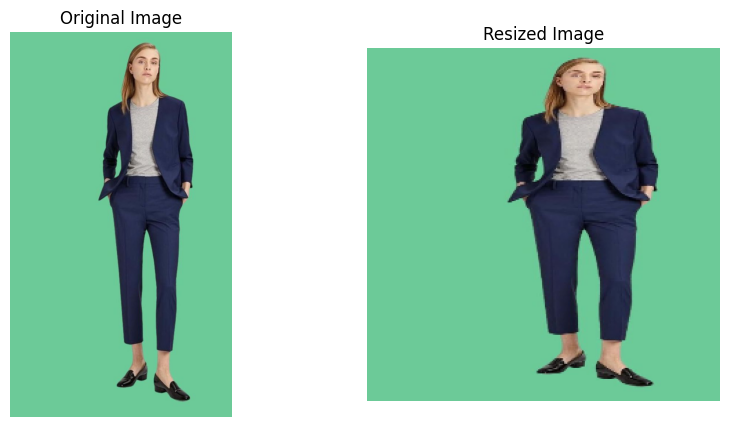

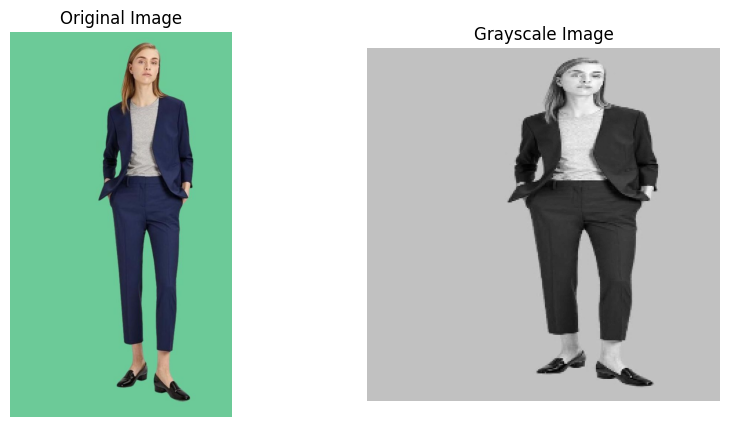

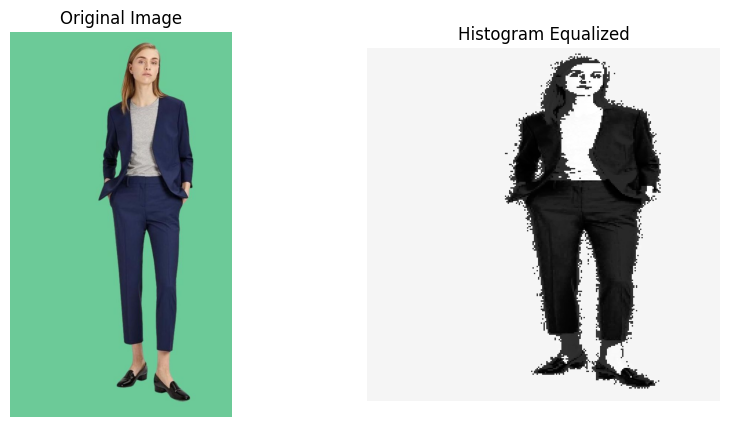

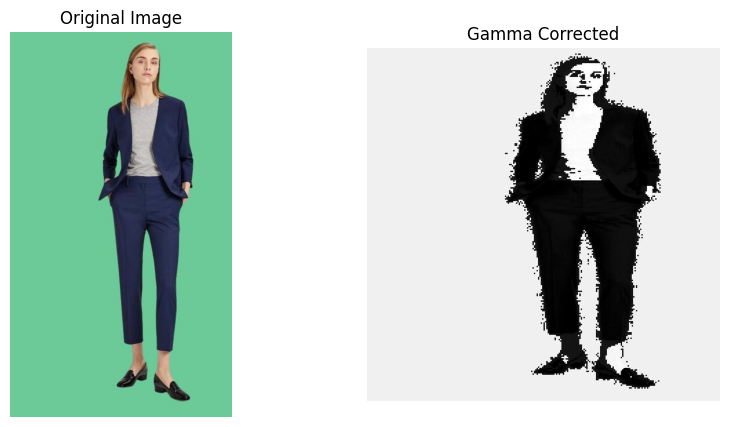

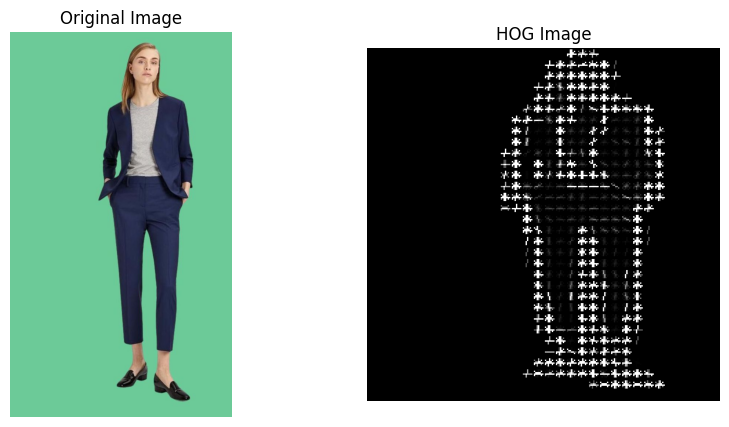

In [ ]:
import cv2
import numpy as np
from skimage.feature import hog
from skimage import exposure
from matplotlib import pyplot as plt

#load
image_path = '/content/drive/MyDrive/test1.jpg'
image = cv2.imread(image_path)


if image is None:
    print(f"Error: Could not load image from {image_path}")
else:
    target_size = (256, 256)

    #resize
    resized_image = cv2.resize(image, target_size)

    #grayscale
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

    #histogram equalization
    equalized_image = cv2.equalizeHist(gray_image)

    #gamma correction
    gamma = 1.5
    gamma_corrected = np.uint8(cv2.pow(equalized_image / 255.0, gamma) * 255.0)

    # Extract HOG features and HOG image
    features, hog_image = hog(gamma_corrected,
                              orientations=9,
                              pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2),
                              visualize=True,
                              channel_axis=None)

    #rescale histogram for better display
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    def display_images_side_by_side(image1, image2, title1, title2):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        if len(image1.shape) == 2:  # grayscale image
            plt.imshow(image1, cmap='gray')
        else:  # color image
            plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
        plt.title(title1)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        if len(image2.shape) == 2:  # grayscale image
            plt.imshow(image2, cmap='gray')
        else:  # color image
            plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
        plt.title(title2)
        plt.axis('off')

        plt.show()

    # List of images and their titles
    images = [image, resized_image, gray_image, equalized_image, gamma_corrected, hog_image_rescaled]
    titles = ['Original Image', 'Resized Image', 'Grayscale Image', 'Histogram Equalized', 'Gamma Corrected', 'HOG Image']
    display_images_side_by_side(image, resized_image, 'Original Image', 'Resized Image')
    display_images_side_by_side(image, gray_image, 'Original Image', 'Grayscale Image')
    display_images_side_by_side(image, equalized_image, 'Original Image', 'Histogram Equalized')
    display_images_side_by_side(image, gamma_corrected, 'Original Image', 'Gamma Corrected')
    display_images_side_by_side(image, hog_image_rescaled, 'Original Image', 'HOG Image')


Train SVM

In [ ]:
import os
def load_dataset(dataset_path):
    X = []
    y = []
    for label in os.listdir(dataset_path):
        label_path = os.path.join(dataset_path, label)
        if os.path.isdir(label_path):
            for image_name in os.listdir(label_path):
                image_path = os.path.join(label_path, image_name)
                image = preprocess_image(image_path)
                if image is not None:
                    features = extract_hog_features(image)
                    X.append(features)
                    y.append(label)
    return np.array(X), np.array(y)

#train-test
train_path = '/content/drive/MyDrive/dataset/train'
test_path = '/content/drive/MyDrive/dataset/val'

#load and extract
X_train, y_train = load_dataset(train_path)
X_test, y_test = load_dataset(test_path)

#SVM
clf = svm.SVC(kernel='linear')

#train svm
clf.fit(X_train, y_train)

#predict test data
y_pred = clf.predict(X_test)

#evaluate svm
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

<ipython-input-9-07c825c71632>:12: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  features, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),


Accuracy: 0.8333333333333334


Test on Single Image

<ipython-input-9-07c825c71632>:12: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  features, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),


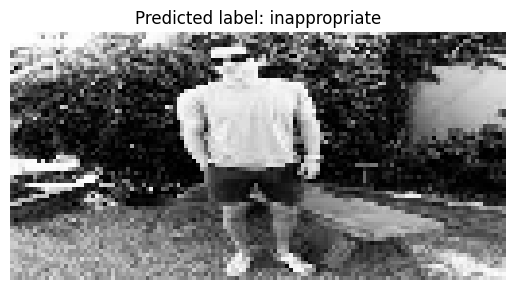

Predicted label: inappropriate


In [ ]:
import cv2
import matplotlib.pyplot as plt


def classify_and_display_image(model, image_path):

    image = preprocess_image(image_path)
    if image is None:
        print(f"Warning: Unable to preprocess image {image_path}")
        return None, None

    #extract HOG features
    features = extract_hog_features(image)

    #predict label
    prediction = model.predict(features.reshape(1, -1))

    # Display the image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted label: {prediction[0]}")
    plt.axis('off')
    plt.show()


    return image, prediction[0]

#test image
image_path = '/content/drive/MyDrive/test6.jpg'


image, prediction = classify_and_display_image(clf, image_path)

print("Predicted label:", prediction)


Test on Multiple Images

<ipython-input-9-07c825c71632>:12: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  features, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),


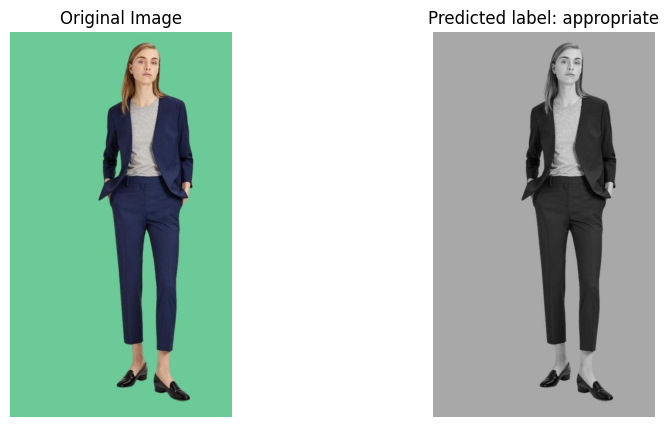

Predicted label: appropriate


<ipython-input-9-07c825c71632>:12: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  features, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),


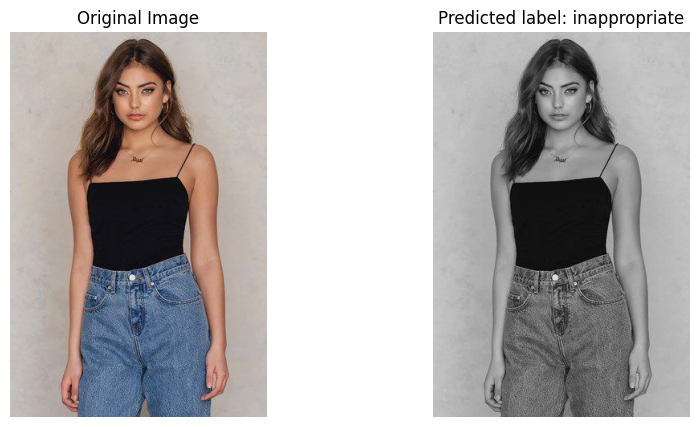

Predicted label: inappropriate


<ipython-input-9-07c825c71632>:12: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  features, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),


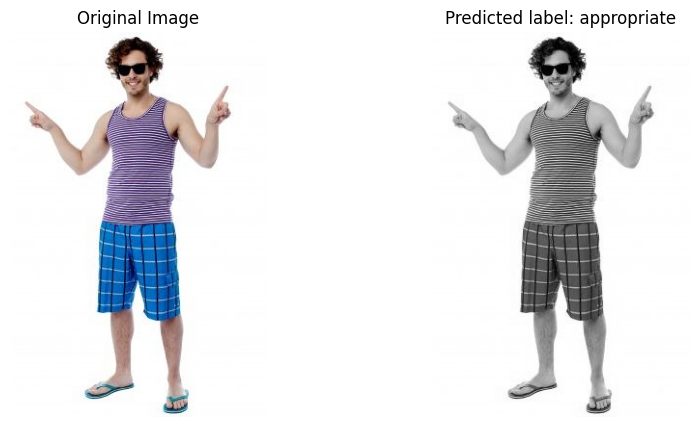

Predicted label: appropriate


<ipython-input-9-07c825c71632>:12: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  features, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),


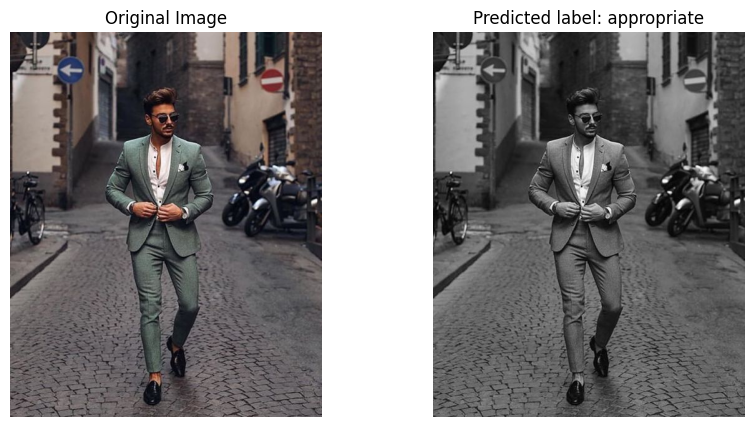

Predicted label: appropriate


<ipython-input-9-07c825c71632>:12: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  features, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),


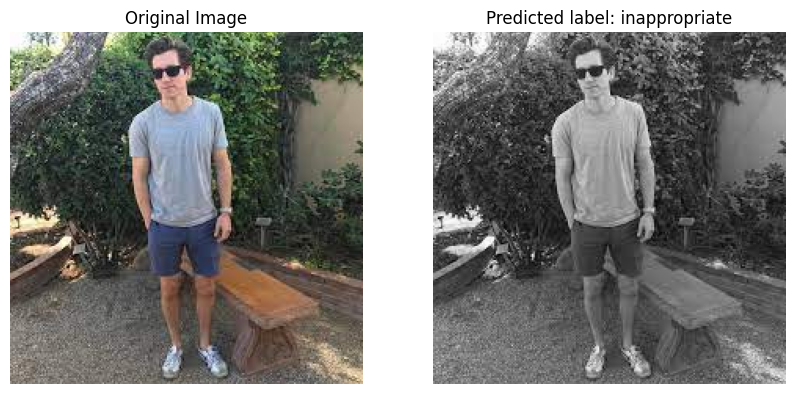

Predicted label: inappropriate


In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def classify_and_display_images(model, image_paths):
    for image_path in image_paths:
        #convert image path to string
        image_path = str(image_path)

        #ori image
        original_image = cv2.imread(image_path)
        if original_image is None:
            print(f"Warning: Unable to read image {image_path}")
            continue

        #preprocess
        image = preprocess_image(image_path)
        if image is None:
            print(f"Warning: Unable to preprocess image {image_path}")
            continue

        #extract HOG features
        features = extract_hog_features(image)

        #predict label
        prediction = model.predict(features.reshape(1, -1))

        #color segmentation
        segmented_image = perform_color_segmentation(original_image)

        #display original image
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
        plt.title("Original Image")
        plt.axis('off')

        #display segmented image
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
        plt.title(f"Predicted label: {prediction[0]}")
        plt.axis('off')

        plt.show()

        #print predicted label
        print("Predicted label:", prediction[0])

image_paths = ['/content/drive/MyDrive/test1.jpg',
               '/content/drive/MyDrive/test2.jpg',
               '/content/drive/MyDrive/test3.jpg',
               '/content/drive/MyDrive/test4.jpg',
               '/content/drive/MyDrive/test5.jpg',
               '/content/drive/MyDrive/test6.jpg']

classify_and_display_images(clf, image_paths)


Confusion Matrix

In [20]:
from sklearn.metrics import confusion_matrix

y_true = np.array([0, 1, 1, 0, 1])
y_pred = np.array([0, 1, 0, 0, 1])

cm = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[2 0]
 [1 2]]


Evaluation Metrics

Accuracy: 0.8
Precision: 1.0
Recall: 0.6666666666666666
F1-score: 0.8
AUC: 0.8333333333333333


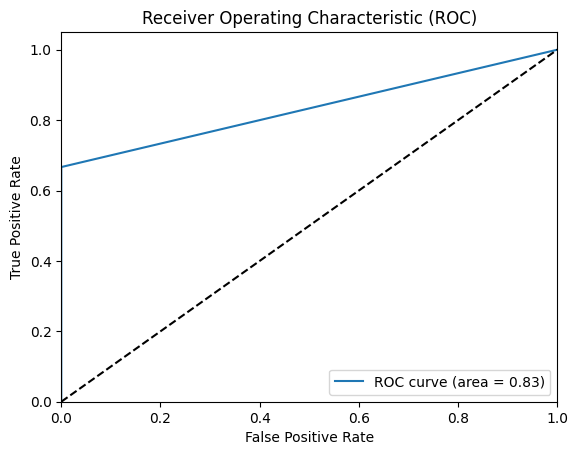

In [21]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

y_true = np.array([0, 1, 1, 0, 1])
y_pred = np.array([0, 1, 0, 0, 1])

#accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

#precision
precision = precision_score(y_true, y_pred)
print("Precision:", precision)

#recall
recall = recall_score(y_true, y_pred)
print("Recall:", recall)

#f1-score
f1 = f1_score(y_true, y_pred)
print("F1-score:", f1)


if len(np.unique(y_true)) == 2:
    auc = roc_auc_score(y_true, y_pred)
    print("AUC:", auc)

    #ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
else:
    print("AUC is not applicable for multi-class classification tasks.")
